
#  Set paths and get a list of all test images


In [1]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import os
import tensorflow_addons as tfa
#set path to model folder
model_path = 'D:\\PRS_project\Model\\blue_whitish'

#input name of model to be tested
model_name = 'DenseNet121.hdf5'

#set path to test images
test_image_path_pos = 'D:\\PRS_project\\Data_Set_7-pt\\test\\blue_whitish\\'
test_image_path_neg = 'D:\\PRS_project\\Data_Set_7-pt\\test\\non_blue_whitish\\'

#load model to be tested
model = load_model(os.path.join(model_path,model_name))

#getting the lists of melanoma and non_melanoma images
image_list_pos = os.listdir(test_image_path_pos)
image_list_neg = os.listdir(test_image_path_neg)

image_list_all = []
for image in image_list_pos:
    image_list_all.append(os.path.join(test_image_path_pos,image))
for image in image_list_neg:
    image_list_all.append(os.path.join(test_image_path_neg,image))

# Function to preprocess test images to feed into model

In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image

#preprocessing images to a nparray
def image_preprocessing_all(img_list):
    images = []
    for img in img_list:
        img = image.load_img(img,target_size=(224,224))
        images.append(np.asarray(img))
    images_np = np.array(images)
    return images_np

#storing all the test images in nparray format
images_np = image_preprocessing_all(image_list_all) 
print(images_np.shape)

(102, 224, 224, 3)


# Predict test image classes and store results 

In [3]:
from tensorflow.keras.preprocessing import image

#storing the true label for the images in labelled_class
labelled_class = []
for img in image_list_pos:
    labelled_class.append(0)
for img in image_list_neg:
    labelled_class.append(1)
    
#class probabilites for each image in test set
raw_pred_probs = model.predict(images_np)

#class predictions for each image based on probabilities
pred_class = []
for pred in raw_pred_probs:
    if (pred[0] <= 0.5):
        pred_class.append(0)
    elif (pred[0] > 0.5):
        pred_class.append(1)
    
print('Length of raw_pred_probs list: ', len(raw_pred_probs))
print('Array shape of raw_pred_probs[0]: ', raw_pred_probs[0].shape)
print('Length of pred_class list: ', len(pred_class))
print('Length of labelled_class list: ',len(labelled_class))

Length of raw_pred_probs list:  102
Array shape of raw_pred_probs[0]:  (1,)
Length of pred_class list:  102
Length of labelled_class list:  102


# Report classification metrics

In [4]:
import sklearn.metrics as metrics

labelname = ['blue_whitish', 'non_blue_whitish']
testScores  = metrics.accuracy_score(labelled_class,pred_class)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(labelled_class,
                                    pred_class,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 90.20%
                  precision    recall  f1-score   support

    blue_whitish     0.7778    0.7000    0.7368        20
non_blue_whitish     0.9286    0.9512    0.9398        82

        accuracy                         0.9020       102
       macro avg     0.8532    0.8256    0.8383       102
    weighted avg     0.8990    0.9020    0.9000       102



# Model evaluation using accuracy and loss

In [5]:
#generating the labelled_class2D array for evaluation metrics
labelled_class2D = []

for img in image_list_pos:
    labelled_class2D.append((0))
for img in image_list_neg:
    labelled_class2D.append((1))

labelled_class2D = np.array(labelled_class2D)

In [6]:
score = model.evaluate(images_np, np.array(labelled_class2D), verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.02821083925664425
Test accuracy: 0.9019607901573181


# Print Confusion Matrix

In [7]:
confusion   = metrics.confusion_matrix(labelled_class,pred_class)
print(confusion)

[[14  6]
 [ 4 78]]


# AUC Score

In [8]:
from sklearn.metrics import roc_auc_score

#getting the predicted probability list of class melanoma
raw_prob_class_mel = []
for pred in raw_pred_probs:
    raw_prob_class_mel.append(pred[0])

#getting AUC score
roc_auc = roc_auc_score(labelled_class, raw_prob_class_mel)
print("AUC Score: ", roc_auc)

AUC Score:  0.9512195121951219


# Plot ROC curve and save

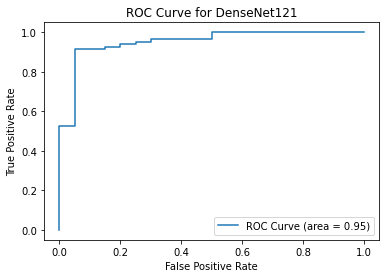

Path to plot: D:\PRS_project\Model\blue_whitishDenseNet121_roc.png


In [9]:
import matplotlib.pyplot as plt

#plotting ROC
fpr, tpr, thresholds = metrics.roc_curve(labelled_class, raw_prob_class_mel, pos_label=0)
plt.figure()
plt.plot(tpr,fpr,label='ROC Curve (area = %0.2f)' %roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for " + model_name.split('.')[0])
plt.legend(loc="lower right")

roc_plotpath  = model_path + model_name.split('.')[0] + '_roc.png'
plt.savefig(roc_plotpath)
plt.show()
print("Path to plot:", roc_plotpath)